# Imports

In [29]:
import os
import torch
import torchvision
import torchvision.transforms as transforms
import pandas as pd
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.models as models
import torch.optim as optim
from PIL import Image

## Processing Data

### Image Transforms

In [30]:
# For training (with augmentation)
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# For validation and testing (without augmentation)
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

### Load Datasets

In [31]:
# Load Dataset with validation/test transform
dataset = ImageFolder(root='../data/filtered', transform=transform)

### Split Datasets

In [32]:
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Apply Training Transform to Training Dataset
train_dataset.dataset.transform = train_transform

### Create Data loaders

In [33]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

### Data Exploration

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


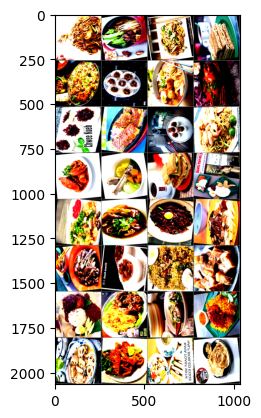

In [34]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    plt.imshow(torch.transpose(img, 0, 2).numpy())
    plt.show()

# Get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images))

## Neutral Net

### NN Definition

In [35]:
class FoodNet(nn.Module):
    def __init__(self, num_classes=25):  # Change num_classes to your dataset's number of classes
        super(FoodNet, self).__init__()
        # Load pre-trained MobileNet model
        self.mobilenet = models.mobilenet_v2(pretrained=True)
        # Replace the classifier layer to match the number of classes
        self.mobilenet.classifier[1] = nn.Linear(self.mobilenet.last_channel, num_classes)

    def forward(self, x):
        return self.mobilenet(x)

model = FoodNet().to(torch.device("cuda" if torch.cuda.is_available() else "cpu"))

### Loss Function and Optimizer

In [36]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [37]:
best_val_loss = float('inf')
best_model_state = None

num_epochs = 10  

for epoch in range(num_epochs):
    model.train()
    # Training loop
    for images, labels in train_loader:
        images, labels = images.to('cuda'), labels.to('cuda')
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    # Validation Loop
    model.eval()
    total = 0
    correct = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to('cuda'), labels.to('cuda')
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_accuracy = 100 * correct / total

    if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_state = model.state_dict().copy()

    print(f'Epoch {epoch+1}, Train Loss: {loss.item()}, Validation Loss: {val_loss}, Validation Accuracy: {val_accuracy}%')



Epoch 1, Train Loss: 1.022434949874878, Validation Loss: 1.0339848101139069, Validation Accuracy: 67.6470588235294%
Epoch 2, Train Loss: 1.2185149192810059, Validation Loss: 1.013721717255456, Validation Accuracy: 71.26696832579185%
Epoch 3, Train Loss: 0.8889142274856567, Validation Loss: 0.8886540361813137, Validation Accuracy: 74.43438914027149%
Epoch 4, Train Loss: 0.5279031991958618, Validation Loss: 0.703860627753394, Validation Accuracy: 78.50678733031674%
Epoch 5, Train Loss: 0.789284348487854, Validation Loss: 0.6479895072323936, Validation Accuracy: 80.99547511312217%
Epoch 6, Train Loss: 0.3312379717826843, Validation Loss: 0.6196783248867307, Validation Accuracy: 82.57918552036199%
Epoch 7, Train Loss: 0.32592344284057617, Validation Loss: 0.4603406297309058, Validation Accuracy: 85.29411764705883%
Epoch 8, Train Loss: 0.24117806553840637, Validation Loss: 0.3336500993796757, Validation Accuracy: 89.36651583710407%
Epoch 9, Train Loss: 1.3136576414108276, Validation Loss: 0

### Load the best model

In [38]:
model.load_state_dict(best_model_state)

<All keys matched successfully>

### Model Evaluation

In [39]:
## Test the Model
model.eval()
test_loss = 0.0
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss /= len(test_loader)
test_accuracy = 100 * correct / total
print(f'Test Loss: {test_loss}, Test Accuracy: {test_accuracy}%')

Test Loss: 0.7015395047409194, Test Accuracy: 83.33333333333333%


### Save Model

In [40]:
torch.save(model.state_dict(), 'food_model, 256x256.pth')

## Test with your own image

In [49]:
# Path to the test folder
test_folder = '../data/test'

# Define the transform
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Ensure the model is in evaluation mode
model.eval()

# Iterate through each file in the test folder
for filename in os.listdir(test_folder):
    file_path = os.path.join(test_folder, filename)
    
    # Check if the file is an image
    if os.path.isfile(file_path) and file_path.lower().endswith(('.png', '.jpg', '.jpeg', '.webp')):
        image = Image.open(file_path)

        # Apply the transformation
        image = transform(image).unsqueeze(0)  # Add batch dimension

        # Predict with the model
        with torch.no_grad():
            image = image.to('cuda') if torch.cuda.is_available() else image
            outputs = model(image)
            _, predicted = torch.max(outputs.data, 1)
            predicted_class = dataset.classes[predicted.item()]

        # Print the result
        print(f'Image: {filename}, Predicted Class: {predicted_class}')

Image: BKT.jpeg, Predicted Class: pork_ribs_soup
Image: BKT2.png, Predicted Class: pork_ribs_soup
Image: CK.jpg, Predicted Class: Chwee_Kueh
Image: CLC.jpg, Predicted Class: fish_head_curry
Image: CSF.jpg, Predicted Class: crispy_roasted_pork_rice
Image: LS.jpg, Predicted Class: laksa
Image: NSBYN.jpg, Predicted Class: nasi_biryani
Image: NSLM.webp, Predicted Class: crispy_roasted_pork_rice
Image: NSLM2.webp, Predicted Class: nasi_lemak
Image: SRF.jpg, Predicted Class: crispy_roasted_pork_rice
Image: ST.jpg, Predicted Class: satay


## Convert Model for Mobile Deployment

In [42]:
model.eval()
example = torch.rand(1, 3, 256, 256).to('cuda')  # An example input you expect to receive
traced_script_module = torch.jit.trace(model, example)
traced_script_module.save("food_model_mobile.pt")